# Modeling a roulette wheel in vanilla Python

The first thing to do is model the possible results.  The places where the ball can settle are called "pockets."  American roulette has two green pockets call "0" and "00."  I'm going to lazily label the double zero pocket as -1 for now.  The rest of the pockets are evenly (though irregularly) divided between red and black.

In [35]:
POCKETS =(
    (-1, 'green'),
    (0, 'green'),
    (1, 'red'),
    (2, 'black'),
    (3, 'red'),
    (4, 'black'),
    (5, 'red'),
    (6, 'black'),
    (7, 'red'),
    (8, 'black'),
    (9, 'red'),
    (10, 'black'),
    (11, 'black'),
    (12, 'red'),
    (13, 'black'),
    (14, 'red'),
    (15, 'black'),
    (16, 'red'),
    (17, 'black'),
    (18, 'red'),
    (19, 'red'),
    (20, 'black'),
    (21, 'red'),
    (22, 'black'),
    (23, 'red'),
    (24, 'black'),
    (25, 'red'),
    (26, 'black'),
    (27, 'red'),
    (28, 'black'),
    (29, 'black'),
    (30, 'red'),
    (31, 'black'),
    (32, 'red'),
    (33, 'black'),
    (34, 'red'),
    (35, 'black'),
    (36, 'red'))

We'll use the `choice()` function from Python's standard library to simulate the ball landing in a random pocket each round.

In [36]:
from random import choice

Here's an example of calling `random.choice()` with the `POCKETS` we defined above.

In [37]:
display(choice(POCKETS))

(20, 'black')

Let's make sure that the results of calling `choice(POCKETS)` repeatedly looks like we'd expect.  We expect each possible result to be equally likely.  We can add up the frequencies of lots of objects using `collections.Counter()`

In [38]:
from collections import Counter

In [39]:
million_spins = tuple(choice(POCKETS) for _ in range(1_000_000))
million_spin_frequencies = sorted(Counter(million_spins).most_common())
print("Pocket\tFrequency")
for pocket in million_spin_frequencies:
    print(f"{pocket[0][0]}\t{pocket[1]:,g}")

Pocket	Frequency
-1	26,266
0	26,587
1	26,343
2	26,313
3	26,234
4	25,956
5	26,225
6	26,408
7	26,342
8	26,505
9	26,198
10	26,691
11	26,402
12	26,288
13	26,179
14	26,396
15	26,063
16	26,176
17	26,238
18	26,181
19	26,418
20	26,145
21	26,401
22	26,176
23	26,393
24	26,239
25	26,327
26	26,423
27	26,011
28	26,379
29	26,378
30	26,680
31	26,350
32	26,519
33	26,309
34	26,341
35	26,324
36	26,196


The table's a bit long, perhaps a graph?

In [40]:
import matplotlib.pyplot as plt

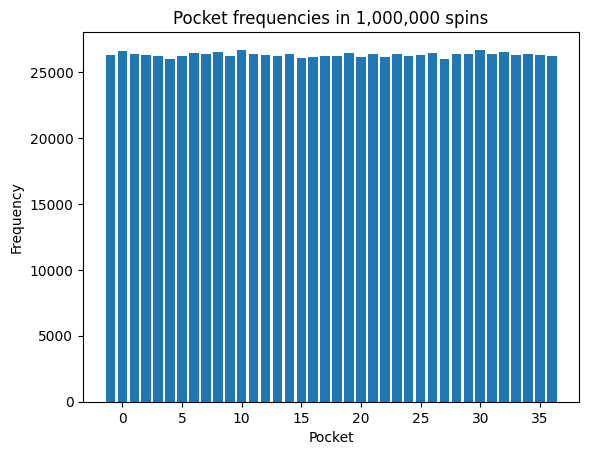

In [41]:
fig, ax = plt.subplots()
ax.bar([pocket[0][0] for pocket in million_spin_frequencies], [pocket[1] for pocket in million_spin_frequencies])
ax.set_title("Pocket frequencies in 1,000,000 spins")
ax.set_xlabel("Pocket")
ax.set_ylabel("Frequency")
plt.show()

That seems relatively uniform to me.

The next step is to model some bets, meaning a funciton that takes the round's winning pocket and the player's bet and returns how their balance should change.  The strategies that we want to test focus on "outside" bets, specifically the ones with the most even odds such as even, odd, red, or black, so I will start with those.

In [42]:
def bet_even(pocket, bet):
    pocket_number, pocket_color = pocket
    if pocket_number > 0 and pocket_number % 2 == 0:
        return bet
    else:
        return -bet


In [43]:
def bet_odd(pocket, bet):
    pocket_number, pocket_color = pocket
    if pocket_number > 0 and pocket_number % 2 == 1:
        return bet
    else:
        return -bet

In [44]:
def bet_red(pocket, bet):
    pocket_number, pocket_color = pocket
    if pocket_color == "red":
        return bet
    else:
        return -bet

In [45]:
def bet_black(pocket, bet):
    pocket_number, pocket_color = pocket
    if pocket_color == "black": 
        return bet
    else: 
        return -bet

Let's test these betting strategies with a sample bet of $1 just to see if they behave the way we expect.

Test Even:

In [46]:
for round in range(10):
    winning_pocket = choice(POCKETS)
    result = bet_even(winning_pocket, 1)
    print(f"{winning_pocket} {result}")

(16, 'red') 1
(17, 'black') -1
(11, 'black') -1
(16, 'red') 1
(16, 'red') 1
(2, 'black') 1
(-1, 'green') -1
(4, 'black') 1
(20, 'black') 1
(-1, 'green') -1


Test odd

In [47]:
for round in range(10):
    winning_pocket = choice(POCKETS)
    result = bet_odd(winning_pocket, 1)
    print(f"{winning_pocket} {result}")

(11, 'black') 1
(4, 'black') -1
(8, 'black') -1
(28, 'black') -1
(9, 'red') 1
(35, 'black') 1
(5, 'red') 1
(2, 'black') -1
(1, 'red') 1
(6, 'black') -1


Test Red

In [48]:
for round in range(10):
    winning_pocket = choice(POCKETS)
    result = bet_red(winning_pocket, 1)
    print(f"{winning_pocket} {result}")

(3, 'red') 1
(24, 'black') -1
(26, 'black') -1
(31, 'black') -1
(26, 'black') -1
(5, 'red') 1
(24, 'black') -1
(19, 'red') 1
(21, 'red') 1
(33, 'black') -1


Test black

In [49]:
for round in range(10):
    winning_pocket = choice(POCKETS)
    result = bet_black(winning_pocket, 1)
    print(f"{winning_pocket} {result}")

(29, 'black') 1
(26, 'black') 1
(10, 'black') 1
(17, 'black') 1
(27, 'red') -1
(9, 'red') -1
(23, 'red') -1
(21, 'red') -1
(17, 'black') 1
(6, 'black') 1


The final step is to model different betting strategies and graph the results.

Let's start with a simple strategy of always betting a fixed amount on red, just to see if we can make the output look useful.

In [50]:
def STRATEGY_RED(starting_funds=100, minimum_bet=3):
    current_funds = starting_funds
    current_bet = minimum_bet
    current_round = 0
    while(current_funds > minimum_bet):
        current_round += 1
        winning_pocket = choice(POCKETS)
        winnings = bet_red(winning_pocket, current_bet)
        new_funds = current_funds + winnings
        print(f"{current_round}\t{current_funds}\t{winning_pocket}\t{winnings}\t{new_funds}")
        current_funds = new_funds

In [63]:
STRATEGY_RED()

1	100	(15, 'black')	-3	97
2	97	(10, 'black')	-3	94
3	94	(19, 'red')	3	97
4	97	(9, 'red')	3	100
5	100	(5, 'red')	3	103
6	103	(24, 'black')	-3	100
7	100	(10, 'black')	-3	97
8	97	(7, 'red')	3	100
9	100	(3, 'red')	3	103
10	103	(11, 'black')	-3	100
11	100	(28, 'black')	-3	97
12	97	(22, 'black')	-3	94
13	94	(27, 'red')	3	97
14	97	(31, 'black')	-3	94
15	94	(34, 'red')	3	97
16	97	(0, 'green')	-3	94
17	94	(11, 'black')	-3	91
18	91	(4, 'black')	-3	88
19	88	(15, 'black')	-3	85
20	85	(14, 'red')	3	88
21	88	(4, 'black')	-3	85
22	85	(0, 'green')	-3	82
23	82	(36, 'red')	3	85
24	85	(3, 'red')	3	88
25	88	(7, 'red')	3	91
26	91	(8, 'black')	-3	88
27	88	(22, 'black')	-3	85
28	85	(5, 'red')	3	88
29	88	(35, 'black')	-3	85
30	85	(36, 'red')	3	88
31	88	(14, 'red')	3	91
32	91	(11, 'black')	-3	88
33	88	(21, 'red')	3	91
34	91	(9, 'red')	3	94
35	94	(8, 'black')	-3	91
36	91	(25, 'red')	3	94
37	94	(19, 'red')	3	97
38	97	(34, 'red')	3	100
39	100	(31, 'black')	-3	97
40	97	(20, 'black')	-3	94
41	94	(5, 'red')	3	97
42	